In [45]:
import numpy as np
import pandas as pd
import pickle
# SQL related packages
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
# sklearn packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics, preprocessing
from sklearn.linear_model import LogisticRegression as Log
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# text analysis packages
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import word2vec, Word2Vec

import matplotlib.pyplot as plt
%matplotlib inline

### Train Word2Vec model using patent claims

In [2]:
# access to sql database
dbname = 'patent_db'
username = 'jy'
pswd = 'jy'

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

# reading from sql database
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

In [3]:
# read data from 2004-2007
years = np.arange(2004, 2008)

# dataframe to store the results
claims = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT claims, id, payment_times, classification
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    claims = pd.concat([claims, results], axis = 0)
    
# check size of the data
claims.shape

(12033, 4)

In [4]:
# extract the response variable
# reformat the response variable into binary
y_data = np.zeros(claims.shape[0])
y_data[claims['payment_times'].values >= 2] = 1

print "Percentage of patents with > 1 maintenance fee payments: ", np.mean(y_data)

Percentage of patents with > 1 maintenance fee payments:  0.628521565694


In [5]:
# remove the patents missing classification data
missing_class_index = (claims['classification'].values == 'NA')

# reassign patent index
claims.index = range(len(claims.index))
# drop the rows
claims =  claims.drop(claims.index[missing_class_index])
claims.shape

(12030, 4)

In [6]:
y_data = y_data[claims['classification'].values != 'NA']
y_data.shape

(12030,)

In [7]:
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(claims, y_data[:claims.shape[0]], 
                                                    test_size = 2000, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (10030, 4)
x_test:  (2000, 4)
y_train:  (10030,)
y_test:  (2000,)


x_train will be combined with additional patent claims data to train the model

In [8]:
# read data from 2008-2010
years = np.arange(2008, 2011)

# dataframe to store the results
claims = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT claims, id, payment_times, classification
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    claims = pd.concat([claims, results], axis = 0)
    
# check size of the data
claims.shape

(11172, 4)

In [10]:
# combine new claims with x_train
train_data = pd.concat([x_train, claims], axis = 0)

In [8]:
def tokenize_cleaning(text):
    # tokenize the text first
    tokens = word_tokenize(text.decode('utf-8'))
    
    # lowercase all the words
    tokens = [w.lower() for w in tokens]
    
    # clean up stop words and punctuations 
    stop_list = stopwords.words('english') + list(string.punctuation)

    tokens_no_stop = [token for token in tokens
                        if token not in stop_list]            
    
#     # extract stem of the words
#     stemmer = PorterStemmer()
#     tokens_stem = [stemmer.stem(token) for token in tokens_no_stop]

    # use lemma instead
    # reason: remove the influence of plural or tense
    # but retain the subtle difference in legal writting
    lemmatizer = WordNetLemmatizer()
    tokens_lemma = [lemmatizer.lemmatize(token) for token in tokens_no_stop]
    
    # remove numbers (the actual values are not useful)
    tokens_no_num = []
    for token in tokens_lemma:
        try:
            float(token)
        except:
            tokens_no_num.append(token)
    
    return tokens_no_num

In [12]:
# tokenize_clean the data for word2vec training

cleaned_text = []
for i in range(train_data.shape[0]):
    tokens = tokenize_cleaning(train_data['claims'].iloc[i])
    cleaned_text.append(tokens)

In [15]:
len(cleaned_text)

21202

In [13]:
model = Word2Vec(cleaned_text, size=100, window=5, min_count=5, workers=4)

In [16]:
model.wv.most_similar(positive=['protein'])

[(u'polypeptide', 0.693970799446106),
 (u'glycoprotein', 0.6489318609237671),
 (u'subunit', 0.6218897104263306),
 (u'adp', 0.6021888256072998),
 (u'repressor', 0.5989565849304199),
 (u'kinase', 0.5918909311294556),
 (u'fusion', 0.5866469740867615),
 (u'mbp', 0.5858468413352966),
 (u'translocation', 0.5848914980888367),
 (u'kda', 0.5842524766921997)]

In [21]:
model.wv.most_similar(positive=['computer'])

[(u'processor', 0.696655809879303),
 (u'microprocessor', 0.6668151617050171),
 (u'software', 0.6461315155029297),
 (u'executable', 0.6111671924591064),
 (u'computer-readable', 0.6046246886253357),
 (u'sub-code', 0.6031157970428467),
 (u'electronically', 0.6021907925605774),
 (u'program', 0.5960052013397217),
 (u'hyperlink', 0.5921428203582764),
 (u'programmed', 0.5846973061561584)]

In [22]:
# save the word2vec model
model.save('models/word2vec_claims_final')

### Training model using the word2vec model

In [9]:
# load the word2vec model
model = Word2Vec.load('models/word2vec_claims_final')

In [23]:
# read data from 2004-2007
years = np.arange(2004, 2008)

# dataframe to store the results
claims = pd.DataFrame()

# import the abstract from each table
for year in years:
    # query:
    sql_query = """
    SELECT claims, id, payment_times, classification
        FROM patents_%s;
    """ %str(year)

    results = pd.read_sql_query(sql_query,con)
    
    claims = pd.concat([claims, results], axis = 0)
    
# check size of the data
claims.shape

(12033, 4)

In [10]:
# remove the patents missing classification data
missing_class_index = (claims['classification'].values == 'NA')

# reassign patent index
claims.index = range(len(claims.index))
# drop the rows
claims =  claims.drop(claims.index[missing_class_index])
claims.shape

(12030, 4)

In [11]:
y_data = y_data[claims['classification'].values != 'NA']
y_data.shape

(12030,)

In [12]:
# tokenize_clean for training the final model

cleaned_text = []
for i in range(claims.shape[0]):
    tokens = tokenize_cleaning(claims['claims'].iloc[i])
    cleaned_text.append(tokens)

In [13]:
# compute average word-vector for a text
def dec_vec(model, text):
    # store the vector for each word
    vectors = []
    
    # compute on each word
    for j in range(len(text)):
        try:
            vectors.append(model.wv[text[j]])
        except:
            continue
    
    if not vectors:
        vectors_mean = np.zeros((1, 100))
    else:
        vectors_mean = np.nanmean(vectors, axis = 0)
        vectors_mean = vectors_mean.reshape((1, 100))
    
    # return vector mean
    return vectors_mean

In [14]:
claims_vec = np.zeros((1, 100))

for i in range(claims.shape[0]):
    vec = dec_vec(model, cleaned_text[i])
    claims_vec = np.concatenate([claims_vec, vec], axis = 0)
    
claims_vec = claims_vec[1:, :]
claims_vec.shape

(12030, 100)

In [15]:
# split the training and testing data
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(claims_vec, y_data, 
                                                    test_size = 2000, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (10030, 100)
x_test:  (2000, 100)
y_train:  (10030,)
y_test:  (2000,)


In [16]:
# sample the same number of'useful' patents as the 'not useful' patents
# size of each class
num_size = np.sum(y_data == 0)

#random shuffle the rows
n = x_train.shape[0]
perm = range(n)
np.random.shuffle(perm)

x_train = x_train[perm]
y_train = y_train[perm]

# separate the two classes
x_useful = x_train[y_train == 1, :]
x_not_useful = x_train[y_train == 0, :]
y_useful = y_train[y_train == 1]
y_not_useful = y_train[y_train == 0]

# sample num_size from the 'useful' class
x_useful = x_useful[:num_size]
y_useful = y_useful[:num_size]

# combine the two classes
x_data_sub = np.concatenate((x_useful, x_not_useful), axis = 0)
y_data_sub = np.concatenate((y_useful, y_not_useful), axis = 0)

# shuffle again
# shuffle the combined data
n2 = x_data_sub.shape[0]
perm2 = range(n2)
np.random.shuffle(perm2)

x_data_sub = x_data_sub[perm2]
y_data_sub = y_data_sub[perm2]

# check the size
print x_data_sub.shape
print y_data_sub.shape

(8217, 100)
(8217,)


In [17]:
# standardize the predictors
scaler = preprocessing.StandardScaler()

x_train_std = scaler.fit_transform(x_data_sub)
x_test_std = scaler.transform(x_test)

In [25]:
# write my own scoring function
def my_loss_func(y_actual, y_pred):
    
    # set the price of applying for each patent
    patent_cost = 20
    
    # set the value of a useful patent
    useful_value = 30
    
    total_cost = np.sum(y_pred == 1) * patent_cost
    total_value = np.sum((y_actual == 1) & (y_pred == 1)) * useful_value
    
    profit = total_value -  total_cost
    
    return profit

my_scorer = make_scorer(my_loss_func, greater_is_better=True)

In [26]:
### tune random forest

model = RandomForestClassifier(n_estimators = 100)

# tune max_features
param_space = np.arange(6, 16, 2)

grid_model = GridSearchCV(model, n_jobs = 4, 
                          param_grid = {'max_features': param_space}, 
                          cv  = 5, scoring = my_scorer)
# fit on the data
grid_model = grid_model.fit(x_train_std, y_data_sub)

In [27]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: -3336.00827553
Best parameter:  {'max_features': 14}


In [28]:
# check confusion matrix
best_rf = grid_model.best_estimator_
best_rf.fit(x_train_std, y_data_sub)

y_pred = best_rf.predict(x_test_std)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_test, y_pred)
print "Precision: ", metrics.precision_score(y_test, y_pred)
print "Recall: ", metrics.recall_score(y_test, y_pred)
print "Net value: ", my_loss_func(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.5885
F1 score:  0.69325382035
Precision:  0.662393162393
Recall:  0.727130570758
Net value:  -180


array([[247, 474],
       [349, 930]])

### Visualize the test data using tSNE

In [36]:
# transform the predictors using tSNE
tSNE = TSNE(n_components=2)

x_tsne = tSNE.fit_transform(x_train_std)
x_tsne.shape

(8217, 2)

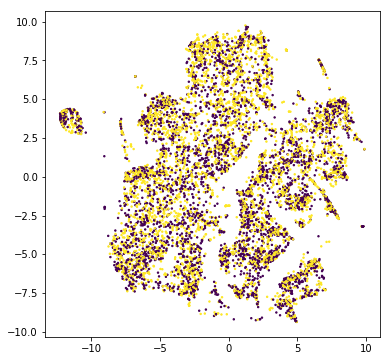

In [43]:
fig = plt.figure(figsize = (6, 6))

plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c = y_data_sub, s = 2)

### Visualize the test data using PCA

In [46]:
# transform the predictors using tSNE
pca = PCA(n_components=2)

x_pca = pca.fit_transform(x_train_std)
x_pca.shape

(8217, 2)

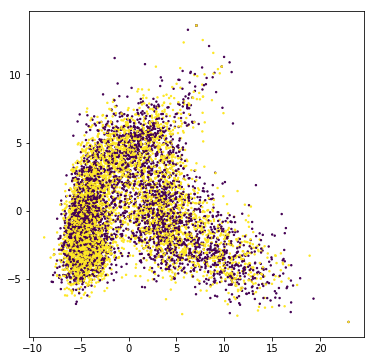

In [47]:
fig = plt.figure(figsize = (6, 6))

plt.scatter(x_pca[:, 0], x_pca[:, 1], c = y_data_sub, s = 2)